# DOC


## DOCUMENTATION
___
### **LLM**

| **Model**                    | **Context Window** |**Limits**           |
|------------------------------|--------------------|---------------------|
| **Qwen 2.5 35B Code**        | Up to 128K tokens  |Fine Tuned for coding|
| **Cohere Command R+**        | Up to 128K tokens  | 1000 calls per month|
| **Mistral-7B-Instruct-v0.3** | 32,768 tokens      | Hallucinations      |

#### Using `Mistral-7B-Instruct-v0.3` because 
- reliable outputs
- 1000 calls per day
- works in huggingface(same as text-to-image)


### **Text-to-Image**


| **Category**               | **Stable Diffusion 3.5 Large Turbo**                                                                 | **FLUX.1-Dev FP16**                                                                       |
|----------------------------|-----------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------|
| **API Endpoint**           | `stabilityai/stable-diffusion-3-5-large-turbo`                                                     | `black-forest-labs/FLUX.1-Dev-FP16`                                                     |
| **Key API Parameters**     | `guidance_scale=3`, `num_inference_steps=4`, `negative_prompt`                                     | `num_inference_steps=8`, `control_image` (Canny/Depth), `true_cfg=4.0`                  |
| **API Latency**            | 3.8–5.2 sec/image (cold start: 12–18 sec)                                                          | 6.1–8.9 sec/image (cold start: 15–22 sec)                                                |
| **Cost Efficiency**        | $0.0021/image (PRO tier)                                                                           | $0.0033/image (PRO tier)                                                                 |
| **Free Tier Limits**       | 500 requests/hour                                                                                  | 300 requests/hour                                                                        |
| **Max Resolution**         | 1024x1024 via single API call                                                                      | 2048x2048 (requires `high_res_fix=true` parameter)                                       |
| **Advanced Features**      | - 4-step inference <br> - Text-to-image only                                                       | - Unified ControlNet (Canny/Depth) <br> - Image-to-image <br> - Inpainting/Outpainting   |
| **NSFW Filtering**         | Enabled by default (`safety_checker=strict`)                                                       | Optional (`safety_checker=relaxed`)                                                      |
| **Rate Limits (PRO)**      | 5K requests/hour                                                                                   | 3K requests/hour                                                                         |
| **Use Case Focus**         | Rapid batch generation (social media, prototyping)                                                 | High-detail workflows (product design, architectural viz)                                |

#### using `SD-3.5-LT` because 
- latency is low
- More requests
- we want stialized images which is better on SD 



___
___
___

### Get **Summary**, **Characters** AND **Places** 

![Local Image](/home/prince/Documents/Project/BOOK/media/Sudo_summary.png "Smmary, characters and Places")

### Imports

In [3]:
from reader import ebook
from utils import read_json
from typing import Optional,Dict,List
import requests
from dotenv import load_dotenv
import json
import os
from pydantic import BaseModel, ValidationError
from dataclasses import dataclass

### API init

In [4]:
load_dotenv()
API = os.getenv("HF_API")

headers = {
    "Authorization": f"Bearer {API}",
    "Content-Type": "application/json",
}
url = "https://api-inference.huggingface.co/models/mistralai/Mistral-7B-Instruct-v0.3/v1/chat/completions"



### Static sum_Role

In [5]:
sum_role='''(NOTE: Only output in JSON. Ensure the JSON format is valid, well-formed, and Ready to parse. nothing before or after the json file)
Input:  
1.Current Chapter Text: The current chapter to be analyzed.
2.Character List: A list of characters with their physical/visual descriptions till now (This chapter).
3.Places list: list of places and their visual description till now (This chapter).
4.Previous Chapters' Summary: Context from earlier chapters.

Rules:  
1.Narrative Summary: Summarize and explain the chapter in detail, integrating context and key developments from previous chapters and create a self containing summary and explaination. end with to be continued.
2.Character List: add new characters to the list based on this chapter and Update existing character's physical/visual descriptions. If no characters are mentioned, return the same list as given.
3.Places: Include an updated description of any significant locations mentioned in this chapter, focusing on environment, weather, vibe, and structure.
4.Output Format: Ensure the output is valid and well-structured JSON.

Output:  
Generate a JSON object in this format:
{
  "summary": "Detailed Summary and explination of the current chapter in context of previous chapters. Use previus chapter summary as context",
  "characters": {
      "Character Name": "Updated or new physical/visual description (age, looks, clothes, hair, body language) based on this chapter."
    },
  "places": {
      "Place Name": "Updated or new visual description (environment, weather, vibe, structure, etc.) based on this chapter."
  }
}
'''

### **get_sum()** Function
![Local Image](/home/prince/Documents/Project/BOOK/media/Get_sum_logic.png "Smmary, characters and Places")


outputdir=
```{
    0:
        {
            "summary":"No previous Context Yet",
            "characters":{},
            "places": {}
        }
            }```


In [4]:


class SummarySchema(BaseModel):
    summary: str
    characters: Dict[str,str]
    places: Dict[str,str]
    

def sum_msg(text: str, role:str, context: str, characters: dict = {}, places: dict = {}) -> list:
    message =[
        {
            "role": "system",
            "content":role,
        },
        {
            "role": "user",
            "content": json.dumps({
                "past_context": context,
                "Current_Chapter": text,
                "character_list": characters,
                "places_list": places
            }),
        },
    ]
    return message

def get_summ(messages:Dict[str,str]) -> Optional[str]:
    data = {
        "messages": messages,
        "temperature": 0.7,
        "stream": False,
        "max_tokens":10000,
        "parameters": {
        "repetition_penalty": 1.3,
        "grammar": {
            "type": "json",
            "value": SummarySchema.model_json_schema()
                }
                    }
    }
    response = requests.post(url, headers=headers, json=data)

    if response.status_code == 200:
        response_data = response.json()
        assistant_message = response_data["choices"][0]["message"]["content"]
        return assistant_message
    else:
        print(f"Error: {response.status_code}, {response.text}")
        return None



In [6]:
from reader import ebook,read_list,read_json
# book=ebook("./books/Alchemist/Alchemist.epub")
book=ebook("./books/stranger.pdf")
title=book.get_metadata()['title']
_,text=zip(*book.get_chapters())
text=text[:3]



In [7]:
output_dict={
    0:
        {
            "summary":"There is no previous context",
            "characters":{},
            "places": {}
        }
            }


____
____


### SummaryLoop

In [8]:
output_dict={
    0:
        {
            "summary":"There is no previous context",
            "characters":{},
            "places": {}
        }
            }

for idx,i in enumerate(text):
 
    if len(i)<1200:
        output_dict[idx+1]=output_dict[idx]
    else:
        context=output_dict[idx]["summary"]
        characters=output_dict[idx]["characters"]
        places=output_dict[idx]["places"]
        
        mes=sum_msg(
            text=i,
            role=sum_role,
            context=context,
            characters=characters,
            places=places
            )
        
        summary_characters=get_summ(mes)
        
        output_json=read_json(summary_characters)
        output_dict[idx+1]=output_json
        
    print(f"chapter: {idx} done")
print(output_dict)

chapter: 0 done
chapter: 1 done
chapter: 2 done
{0: {'summary': 'There is no previous context', 'characters': {}, 'places': {}}, 1: {'summary': "The current chapter starts with the protagonist receiving a telegram about the death of his mother. He plans to travel to Marengo, a village fifty miles from Algiers, to attend the funeral the next day. He recalls lunching at Céleste's restaurant, where everyone was kind and sympathetic. Due to a rush, he had to borrow a black tie and mourning band from Emmanuel. On his journey, he fell asleep and woke up leaning against a soldier. Upon reaching the Home, he asks to see his mother immediately, but is denied and told to wait.", 'characters': {'Protagonist': 'A middle-aged man, dressed in regular clothes. He is somber and preoccupied.'}, 'places': {'Algiers': 'A city where the protagonist lives. It is hot and bustling.', "Céleste's Restaurant": 'A restaurant where the protagonist had lunch. It is a welcoming place with kind and sympathetic patro

In [9]:
for num, dic in output_dict.items():
    if num==0:
        continue
    print(f"CHAPTER {num} :\n")
    
    sum,char,places=dic.items()
    print("Characters:")
    if len(char)>0 :
        for name,i in char[1].items():
            print(f"{name}: {i}")
    
    print("\nPlaces:")
    if len(places)>0:
        for name,i in places[1].items():
            print(f"{name}: {i}")
    print(f"\nSummary:\n{sum[1]}")
    print("\n-------------------------------------------------------------------------------------------------------------------")

CHAPTER 1 :

Characters:
Protagonist: A middle-aged man, dressed in regular clothes. He is somber and preoccupied.

Places:
Algiers: A city where the protagonist lives. It is hot and bustling.
Céleste's Restaurant: A restaurant where the protagonist had lunch. It is a welcoming place with kind and sympathetic patrons.
Marengo: A village fifty miles from Algiers. The Home for Aged Persons is located here.

Summary:
The current chapter starts with the protagonist receiving a telegram about the death of his mother. He plans to travel to Marengo, a village fifty miles from Algiers, to attend the funeral the next day. He recalls lunching at Céleste's restaurant, where everyone was kind and sympathetic. Due to a rush, he had to borrow a black tie and mourning band from Emmanuel. On his journey, he fell asleep and woke up leaning against a soldier. Upon reaching the Home, he asks to see his mother immediately, but is denied and told to wait.

--------------------------------------------------

___
___
___


### Get **Scenes**
![Local Image](/home/prince/Documents/Project/BOOK/media/Sudo_summary.png )

In [10]:
class SceneSchema(BaseModel):
    scenes: Dict[str,str]
print(SceneSchema.model_json_schema())

{'properties': {'scenes': {'additionalProperties': {'type': 'string'}, 'title': 'Scenes', 'type': 'object'}}, 'required': ['scenes'], 'title': 'SceneSchema', 'type': 'object'}


In [47]:
old_scene_role=''' IMPORTANT-> ONLY OUTPUT IN JSON.
                You are a text-to-image prompt generator for for book visulizer.
                Your task is to analyze the provided input text and identify distinct scenes where there are changes in place or time. 
                For each identified scene, create a detailed and descriptive prompt suitable for generating an image.
                Only Consider a Scene change if there is a change in time place or characters.
                only include visual info. dont go into details.
                handle name and pronouns by describing the character/place/object the name refers to.
                
                Characters: Refer to characters by their respective names as mentioned in the text.
                Places: Refer to places by their proper names as mentioned in the text.
                Ensure each prompt captures the scene's mood, setting, and key visual elements.
                
                1. **Input:**
                    - `text`: A block of narrative text.```
                2. **Output:**
                    - {
                        "scene1":"prompt1",
                        "scene2":"prompt2",
                        ...
                    }

                ### Instructions:
                - Identify key changes in location, characters, or significant actions to define separate scenes.
                - Use descriptive language to paint a vivid picture of each scene in the prompt.
                
                   '''



scene_role=''' 
Analyze the input text and:  
1. Detect Scene Changes: Identify shifts in location, time, or significant events.  
2. Generate Scene Prompts: For each scene, create a text-to-image prompt capturing:  
   - Subject: Characters, objects, appearances.  
   - Setting: Location, time, weather, lighting.  
   - Action/Emotion: Key actions and emotional tone.  
   - Symbolism/Subtext: Hidden themes or foreshadowing.  
   - Style: Artistic medium, color palette, composition.  
3. Output JSON: Return a JSON list   

Key Features 
1. Scene Detection: Splits input into scenes based on time/location shifts (e.g., "next morning," "that night").  
2. Precision: Captures character details, environmental cues, and subtext (e.g., owls = magical intrusion).  
3. Style Flexibility: Specifies artistic styles (realism, fantasy) and references (Hopper, Crewdson).  
4. JSON Ready: Outputs a parseable list for automated workflows.  

  
'''

In [44]:
def scene_msg(text: str) -> list:
    message = [
        {
            "role": "system",
            "content":old_scene_role,
        },
        
        {
            "role": "user",
            "content": text,  # This should be your input text that describes the scenes
        },]
        
    return message

def get_scene(scene_msg: list) -> Optional[str]:
    data = {
        "messages": scene_msg,
        "max_tokens": 10000,  # Specify the maximum length of the response
        "temperature": 0,  # Control the randomness of the response
        "stream": False,
        "repetition_penalty": 1.4,
        "grammar": {
            "type": "json",
            "value": SceneSchema.model_json_schema()
                }
        }
    
    response = requests.post(url, headers=headers, json=data,timeout=60)

    # Check the response status code and process the output
    if response.status_code == 200:
        response_data = response.json()
        # Extract the assistant's message content
        assistant_message = response_data["choices"][0]["message"]["content"]
        return assistant_message
    else:
        print(f"Error: {response.status_code}, {response.text}")  # Print error details
        return None

### SceneLoop

In [45]:
def validate_json(data: str):
    try:
        # Parse the JSON using the Pydantic model
        data=read_json(data)
        validated_data = SceneSchema.model_validate(data)
        return (False,validated_data.scenes)
    except ValidationError as e:
        return (True,e.errors())

In [48]:
scene_output_list=[]
print("--Genrating Scenes per chapter--")
for idx,i in enumerate(text):
    inputs=i.replace("\n"," ")
    scene_message = scene_msg(inputs)
    scene_output=get_scene(scene_message)
    if scene_output is None:
        print("None")
        continue
    print(scene_output)
    scene_json_output=validate_json(scene_output)
    scene_output_list.append(scene_json_output)
    print(f"chapter: {idx+1} Done")

--Genrating Scenes per chapter--
{
    "scene1":"In a bustling marketplace, the sun is setting, casting long shadows over the colorful stalls filled with exotic spices, vibrant textiles, and intricate jewelry. A young girl named Aya, with her dark hair tied back in a braid, haggles with a merchant over the price of a delicate scarf.",
    "scene2":"At night, Aya is in her small, dimly lit bedroom, surrounded by books and drawings. She is sitting at a wooden desk, her face illuminated by the soft glow of a candle, as she writes in a journal.",
    "scene3":"The next morning, Aya is in a lush, green forest, following a narrow path. She carries a backpack and a compass, and the sun is shining brightly through the trees.",
    "scene4":"In a quiet village, Aya enters a quaint, stone cottage. An old woman named Mara, with wrinkled skin and kind eyes, greets her warmly. Inside, the cottage is cozy and filled with the scent of fresh bread.",
    "scene5":"Later that day, Aya is standing on a 

___
___
___



## UNIMPLEMENTED


### Get **Style**
![Local Image](/home/prince/Documents/Project/BOOK/media/Get_Style_logic.png )

In [16]:
def basic_llm_req(text: str) -> Optional[str]:
    messages = [
        {
            "role":"system",
            "content":"DO As Asked in The Input"
        },
        {
            "role":"user",
            "content":text
        }
    ]
    
    data = {
        "messages": messages,
        "max_tokens": 10000,  # Specify the maximum length of the response
        "temperature": 0,  # Control the randomness of the response
        "stream": False,
    }
    response = requests.post(url, headers=headers, json=data)

    # Check the response status code and process the output
    if response.status_code == 200:
        response_data = response.json()
        # Extract the assistant's message content
        assistant_message = response_data["choices"][0]["message"]["content"]
        return assistant_message
    else:
        print(f"Error: {response.status_code}, {response.text}")  # Print error details
        return None
 

In [17]:
combined_summary=""
for key,val in output_dict.items():
    val_content=val["summary"].replace("\n"," ")
    if key==0:
        continue
    output_string= f'''{combined_summary}... Chapter{key}: {val_content}'''

In [18]:
style_prompt='''Prompt:
Note - dont give more than asked for. 
"Analyze the following story and provide a list of image style tags that would best suit its themes, settings, and overall mood. 
The response should include the style, period, type of art, color palette etc. 1 tags per entry.
dont explain it just give tags.

**ONLY TAGS**

Response Format:

Style: Realism or Impressionism or Surrealism oretc
Type:Landscape, Portrait or Abstract or etc.
Color Palette:Warm tones or Cool colors or Monochromatic or black and white or etc
Mood:Serene or Dramatic or Melancholic or etc.

reuired:(Style,Type,Color_palette,Mood)
Story
'''

style=basic_llm_req(f'''{style_prompt}:{combined_summary} ''')

In [19]:
style

'Style: Realism\nType: Landscape\nColor Palette: Warm Tones\nMood: Melancholic'

___

## Get **Image**
![Local Image](/home/prince/Documents/Project/BOOK/media/Get_img_logic.png )

In [6]:
from huggingface_hub import InferenceClient
import time

client = InferenceClient(
    # model="strangerzonehf/Qs-Sketch",
    model="strangerzonehf/Flux-Sketch-Sized-LoRA",
    token=API,
)

In [50]:
def get_images(key, text,tag,characters,places):
    image = client.text_to_image(
        f"Text: {text}// context-> characters: {characters}, places:{places}",
        # negative_prompt="hand,feet,text,written,shinny,artificial,unnatural,plastic,words,letters",
        height=480,
        width= 480,
        # guidance_scale=2,
        # num_inference_steps=10
        
    )
    image.save(f"./output/Sketch_{title}_{key}_{tag}.png")

### Loop Logic
![Local Image](/home/prince/Documents/Project/BOOK/media/Image_Loop.png )

In [ ]:

for idx,i in enumerate(scene_output_list):
    chars=output_dict[idx+1]["characters"]
    places=output_dict[idx+1]["places"]
    for jdx,j in enumerate(i):
        ##try except for internal server error
        try:
            key=f"C{idx}S{jdx+1}"
            text=j
            tag=""
            get_images(key=key,text=text,tag=tag,characters=chars,places=places)
            print(f"{key} saved. tag : {tag} ")
            print(f"    prompt:{text} \n    characters:{chars}\n    places:{places}")
        except Exception as e:
            print(f"Error while calling the API :{e} \n waiting for 10 seconds.. ")
            time.sleep(10)
            get_images(key=key,text=text,tag=tag,characters=chars,places=places)
            print(f"{key} saved. tag : {tag} ")
            print(f"    prompt:{text}")


In [30]:
def get_images():
    image = client.text_to_image(
    '''Sketch Sized, Create an epic fantasy scene set in a rugged, mountainous landscape under a stormy, twilight sky. In the foreground, a lone hero stands defiantly, gripping a glowing sword with both hands, his armor battered and cloak billowing in the wind. Far in the distance, a colossal monster towers over the peaks—its head replaced by a massive, jagged sword dripping with blood, and two enormous, serrated blades fused to its arms. The creature’s body is covered in glowing crimson scars and splattered with dark blood, contrasting against its obsidian-black hide. Surrounding the monster are crumbling cliffs, twisted ruins, and eerie spectral lights. The scene is vibrant yet ominous, with rich colors: icy blue mountains, fiery orange skies, and a faint magical glow radiating from the hero’s sword. Add dramatic lighting, mist, and a sense of impending battle.''',
        # negative_prompt="hand,feet,text,written,shinny,artificial,unnatural,plastic,words,letters",
        height=720,
        width= 1280,
        # guidance_scale=2,
        
    )
    image.save(f"1Dash.png")
    return image

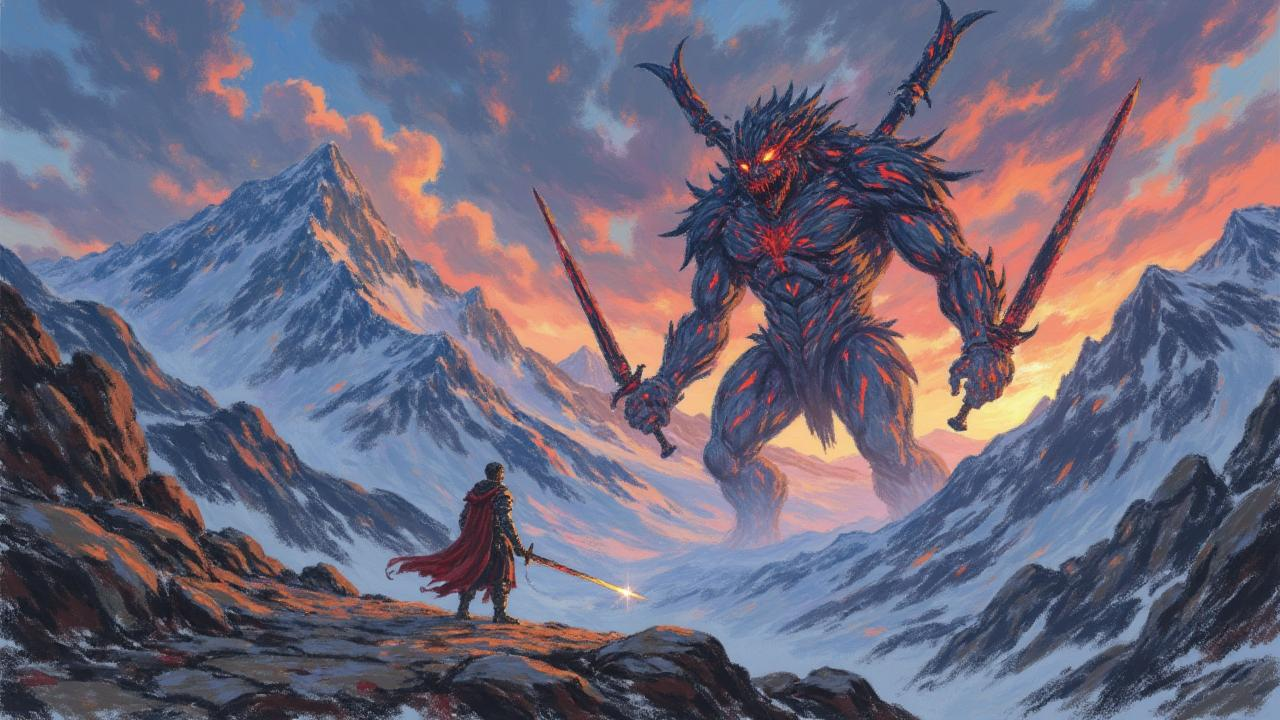

In [31]:
imz=get_images()
imz